In [1]:
import numpy as np
import os
import tensorflow as tf
import tqdm
import PIL
import matplotlib.pyplot as plt
import time
import random

# Setting Resolution and Image Source Path

In [2]:
image_path='/content/drive/MyDrive/GANTheory/Final_GAN'
folder = '/Final_Dense'
os.makedirs(image_path + folder , exist_ok=True)


RESOLUTION = 2
IMG_SIZE = 32 * RESOLUTION
CHANNELS = 3
IMAGES_COUNT = 60000

# ORIG_WIDTH = 178
# ORIG_HEIGHT = 208
# diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

# crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

print(f'Will Generate {IMG_SIZE} x {IMG_SIZE} square images')

Will Generate 64 x 64 square images


# Setting Fixed Parameter

In [3]:
LATENT_DIM = 100
CHANNELS = 3
EPOCHS = 40
NO_OF_PLOTS = 16
BATCH_SIZE = 128

# Preparing the Dataset

## Save a Numpy preprocessed file : Crop Image of size 178x208 to 64x64 

In [4]:
# Image set has 11,682 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.

images=[]
training_binary_path = image_path + '/' + 'Face_' + str(IMG_SIZE) + 'X' + str(IMG_SIZE) + '_' + str(IMAGES_COUNT) + '_sizes.npy'
#training_binary_path = image_path + '/' + 'Face_' + str(IMG_SIZE) + 'X' + str(IMG_SIZE) + '_sizes.npy'
if not os.path.exists(training_binary_path):
  img_source = '/content/drive/MyDrive/GANTheory/CelebA/img_align_celeba'

  
  for pic_file in tqdm.tqdm(os.listdir(img_source)[:IMAGES_COUNT]):
    pic = PIL.Image.open(img_source+'/'+pic_file)
    #pic = PIL.Image.open(img_source+'/'+pic_file).crop(crop_rect)

    # Resize to (IMG_SIZE,IMG_SIZE)
    pic.thumbnail((IMG_SIZE,IMG_SIZE), PIL.Image.ANTIALIAS)  #img = PIL.Image.open(img_source+'/'+file).resize((IMG_SIZE,IMG_SIZE),PIL.Image.ANTIALIAS)
    
    # Convert PIL image to numpy ndarray
    images.append(np.uint8(pic))  #images.append(np.asarray(img)) 

  len(images) # IMAGE_COUNT no of samples, each has image size (IMG_SIZE,IMG_SIZE) pixel
  print("Saving training image binary...")
  np.save(training_binary_path,images)
else:
  images = np.load(training_binary_path)

## Normalization  : Scale from [0,255] to [-1,1]

In [5]:
#training_data = np.reshape(images,(-1,IMG_SIZE,IMG_SIZE,3)).astype('float32')    
training_data = np.array(images).astype('float32')

# Normalized into (-1,1)  i.e scale from [0,255] to [-1,1]
training_data = (training_data-127.5)/127.5
training_data.min(), training_data.max(), images.shape, training_data.shape

(-1.0, 1.0, (60000, 64, 64, 3), (60000, 64, 64, 3))

# Visualize the CelebA dataset images (Denormalized form)

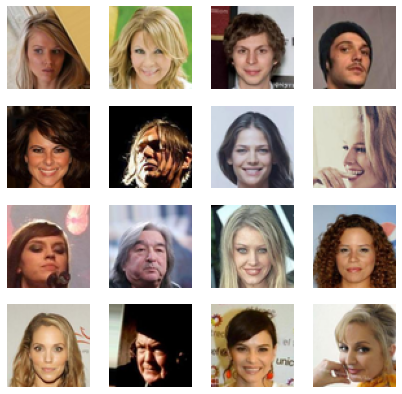

In [6]:
plt.figure(1, figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(((training_data[i]*127.5)+127.5).astype('int'))
    #plt.imshow(((training_data[i]*255)).astype('int'))
    #plt.imshow(training_data[i], cmap='gray', interpolation='none')
    plt.axis('off')
plt.show()

# Model

## Define Discriminator Model

In [7]:
def define_discriminator():
    # Discriminator network
    discriminator = tf.keras.Sequential()

    # Input layer and hidden layer 1      
    discriminator.add(tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))
    discriminator.add(tf.keras.layers.Flatten())
    discriminator.add(tf.keras.layers.Dense(512, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    #discriminator.add(tf.keras.layers.Dropout(0.3))
    # (None, 512) 

    # Hidden layer 2
    discriminator.add(tf.keras.layers.Dense(256))
    discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    #discriminator.add(tf.keras.layers.Dropout(0.3))
    # (None, 256) 


    # Output layer
    discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # (None, 1) 

    # compile model   
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'] )
    
    return discriminator
  

discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 512)               6291968   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,423,553
Trainable params: 6,423,553
Non-

## Define Generator Model

In [8]:
def define_generator():
		# Generator network
		generator = tf.keras.Sequential()

		# Input layer and hidden layer 1
		generator.add(tf.keras.layers.Dense(256, input_shape=(LATENT_DIM, ), kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02) ))
		#(None, 256)
		generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
		generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))


		# Hidden layer 2
		generator.add(tf.keras.layers.Dense(512)) # (None, 512)
		generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
		generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))


		# # Output layer 
		generator.add(tf.keras.layers.Dense(IMG_SIZE*IMG_SIZE*CHANNELS, activation='tanh'))  #(None, 64*64*3) 
		generator.add(tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE,CHANNELS)))
		return generator


generator = define_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                      

## Define GAN : Combined Generator with Discriminator model

In [9]:
# define the combined generator and discriminator model, for updating the generator
def define_gan():
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	
	model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
 #optimizer = tf.keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)


# gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.5),
#             loss=tf.keras.losses.BinaryCrossentropy(),
#             metrics=['accuracy'] )

# gan.compile(optimizer=tf.keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8),
#             loss=tf.keras.losses.BinaryCrossentropy(),
#             metrics=['accuracy'] )
	return model


gan = define_gan()
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 64, 64, 3)         6464256   
                                                                 
 sequential (Sequential)     (None, 1)                 6423553   
                                                                 
Total params: 12,887,809
Trainable params: 6,462,720
Non-trainable params: 6,425,089
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Clear previous images generated after previous training

In [10]:
for f in os.listdir(image_path + folder):
  if f.endswith('.png'):
    os.remove(image_path + folder + '/'+f)

# Visualize the Generated Images (generated by Generator Model)

<function matplotlib.pyplot.show>

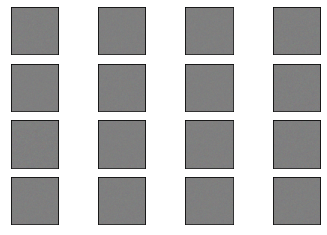

In [11]:
FIXED_SEED = np.random.normal(loc=0, scale=1, size=(NO_OF_PLOTS, LATENT_DIM))
img_fake = generator.predict(FIXED_SEED)
#img_fake = img_fake.clip(np.min(training_data), np.max(training_data))
for i in range(NO_OF_PLOTS):    
    plt.subplot(int(np.sqrt(NO_OF_PLOTS)), int(np.sqrt(NO_OF_PLOTS)), i+1)
    #plt.imshow((img_fake[i]*255).astype('uint8'))
    plt.imshow(((img_fake[i]*127.5)+127.5).astype('int'))

    plt.xticks([])
    plt.yticks([])
plt.savefig(image_path + folder + '/image_at_epoch_{:04d}.png'.format(0))
plt.show

## Discriminator Assigns Target Value 1 To Real Samples

In [12]:
def generate_real_samples(batch_no, batch_step,indices, real_samples):
  # Select particular batch_indices from original indices starting from batch_no
  batch_indices = indices[batch_no: batch_no + batch_step]

  # Shuffle the batches indices
  np.random.shuffle(batch_indices)

  # Discriminator REAL samples based on batch_indices 
  X = real_samples[batch_indices]  # X.shape (batch_size, IMG_SIZE,IMG_SIZE,CHANNELS)
  
  # Discriminator REAL Labels
  y = np.ones((batch_step,1)) # y.shape(batch_size, 1)
  
  #y += .05 * np.random.random(y.shape)
  return X,y

## Discriminator Assigns labels 0 to Fake Samples

In [13]:
def generate_latent_vectors(batch_size, z_dim):
  latent_vectors = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
  return latent_vectors

In [14]:
def generate_fake_samples(batch_size, z_dim):
    # Noise vectors
    z_vectors = generate_latent_vectors(batch_size, z_dim)

    # Generate fake samples
    G_z = generator.predict_on_batch(z_vectors)

    # Discriminator Fake Labels
    y = np.zeros((batch_size,1))
    return G_z, y

## Generates fake samples and save the plot

In [15]:
# generate samples and save as a plot and save the model
def summarize_performance(step, fixed_z, n_samples=16):
  figure = plt.figure(figsize=(7,7))

  # prepare fake samples
  fake_imgs = generator.predict(fixed_z)

  # Clip the fake images
  #fake_imgs = fake_imgs.clip(np.min(training_data), np.max(training_data))

  # plot fake samples
  for i in range(n_samples):   
    # define subplot
    plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), i+1)  

    # plot raw pixel data  : # scale from [-1,1] to [0,255]
    plt.imshow(((fake_imgs[i] * 127.5) + 127.5).astype('int'))

    # turn off axis
    plt.axis('off')
  # save plot to file
  plt.savefig(image_path + folder + '/image_at_epoch_{:04d}.png'.format(step))
  plt.show()
  return plt
  #plt.close()
  

## Plotting Loss and Accuracy for evaluating the performance of GAN model

In [16]:
# create a line plot of loss for the gan and save to file
def plot_history(gen_hist, disc_hist, d_real_acc_hist, d_fake_acc_hist):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(disc_hist, label='discriminator avg loss')
    plt.plot(gen_hist, label='generator avg loss')
    plt.title('Fully Connected Neural Network')
    plt.ylabel('Avg loss')
    plt.xlabel('Epochs')
    plt.legend()

    
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(d_real_acc_hist, label='disc-real-samples-acc(avg)')
    plt.plot(d_fake_acc_hist, label='disc-fake-samples-acc(avg)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # save plot to file
    plt.savefig(image_path + folder + '/plot_line_plot_loss.jpg')
    #plt.close()
    plt.show()
    return plt

In [17]:
# # Nicely formatted time string
# def hms_string(sec_elapsed):
#     h = int(sec_elapsed / (60 * 60))
#     m = int((sec_elapsed % (60 * 60)) / 60)
#     s = sec_elapsed % 60
#     return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Training the GAN Model : Discriminator and Generator

In [18]:
# Remove this part  #################
# EPOCHS = 2
# training_data = training_data[:1000]

# print(training_data.shape)
#####################################
indices = np.arange(len(training_data)) 

d1_epoch_acc, d2_epoch_acc, d_epoch_loss = list(),list(),list()
g_epoch_loss = list()



images_saved=1  # 0 is for fake samples
start_time = time.time()
for epoch in range(EPOCHS):
    batch_start_time = time.time()
    
    
    d1_batch_acc = []
    d2_batch_acc = []

    d_batch_loss = []
    g_batch_loss = []

    for batch_no in tqdm.tqdm(range(0, len(training_data), BATCH_SIZE)): # [0, 128, 256, 384,512, 640, 768, 896...]
        batch_step = min(BATCH_SIZE,  len(training_data)-batch_no )
        #batch_indices = indices[batch_no: batch_no + batch_step]
             
        #half_batch = int(batch_step / 2)  

        # Train the discriminator
        #discriminator.trainable=True
        X_real, y_real = generate_real_samples(batch_no, batch_step,indices,training_data) 
       	
         # update discriminator model weights using real samples
        d_loss1, d_acc1 = discriminator.train_on_batch(X_real, y_real)

        X_fake,y_fake = generate_fake_samples(batch_step, LATENT_DIM)

         # update discriminator model weights using fake samples
        d_loss2, d_acc2 = discriminator.train_on_batch(X_fake, y_fake)

        # Train the Generator using Discriminator
            # prepare points in latent space as input for the generator
        X_gan = generate_latent_vectors(batch_step, LATENT_DIM)

           # create inverted labels for the fake samples : Generator assigns label 1 to fake samples
        y_gan = np.ones((batch_step, 1))

            # update the generator via the discriminator's error
        g_loss = gan.train_on_batch(X_gan, y_gan)  # return [loss only]
        
        # Accumulate Loss in batchwise wise
        #d1_batch_loss.append(d_loss1)  #<-------------------
        #d2_batch_loss.append(d_loss2) #<--------------------------

        g_batch_loss.append(g_loss)
        d_batch_loss.append(0.5 * (d_loss1 + d_loss2))

        # Accumulate Accuracy in batchwise
        d1_batch_acc.append(d_acc1)
        d2_batch_acc.append(d_acc2)


        
    g_loss = sum(g_batch_loss) / len(g_batch_loss)
    d_loss = sum(d_batch_loss) / len(d_batch_loss)

    d_real_acc = sum(d1_batch_acc)/len(d1_batch_acc) # Average Accuracy for real samples
    d_fake_acc = sum(d2_batch_acc)/len(d2_batch_acc)  # Avg Accuracy for fake samples

    # Accumulate Average Loss in Epochs Wise
   # d1_epoch_loss.append(d_loss1)   
   # d2_epoch_loss.append(d_loss2)
    
    d1_epoch_acc.append(d_real_acc)
    d2_epoch_acc.append(d_fake_acc)

    g_epoch_loss.append(g_loss)
    d_epoch_loss.append(d_loss)

    #print('%d/%d: d_loss: %.4f,  g_loss: %.4f. d_real_acc: %d, d_fake_acc: %d (%.1f sec)' % (epoch + 1, EPOCHS, d_epoch_loss[-1], g_epoch_loss[-1], (100*d1_epoch_acc[-1]), (100*d2_epoch_acc[-1]),time.time() - batch_start_time))
    t = time.strftime("%H:%M:%S", time.gmtime(time.time() - batch_start_time))
    print('%d/%d: d_loss: %.4f,  g_loss: %.4f. d_real_acc: %d, d_fake_acc: %d (%s sec)' % (epoch + 1, EPOCHS, d_epoch_loss[-1], g_epoch_loss[-1], (100*d1_epoch_acc[-1]), (100*d2_epoch_acc[-1]), t))


    # Evaluate the Generator Model after every epoch
    if epoch % 2 == 0:
          summarize_performance(epoch+1, FIXED_SEED, n_samples=16)
          images_saved +=  1

end_time = time.time()



Output hidden; open in https://colab.research.google.com to view.

## Time Taken To Train The GAN Model

In [19]:
# Converting seconds to h:m:s
seconds =end_time - start_time
convert = time.strftime("%H:%M:%S", time.gmtime(seconds))
print('Total Time take to train the GAN model ',convert)

Total Time take to train the GAN model  00:16:19


# Save the Generator & Discriminator model 

In [20]:
generator.save(image_path + folder +'/generator_' +str(IMG_SIZE)+'.h5')
discriminator.save(image_path + folder +'/discriminator_' +str(IMG_SIZE)+'.h5')

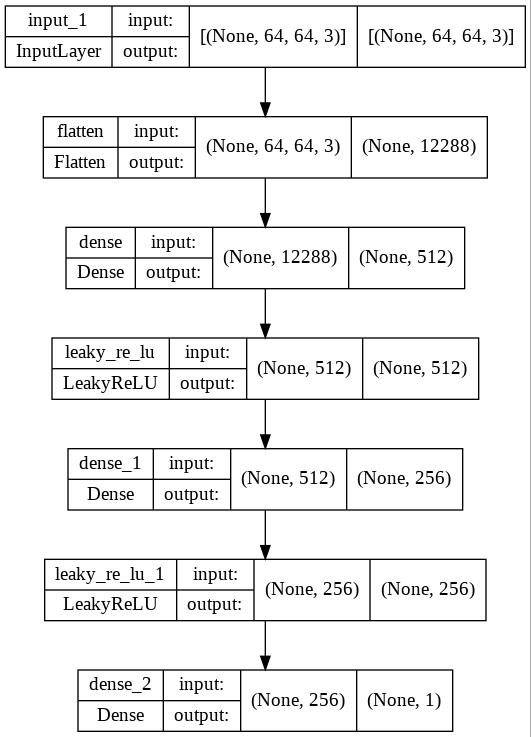

In [21]:
tf.keras.utils.plot_model(discriminator,to_file=image_path + folder+'/disc_archi.jpg',show_shapes=True)

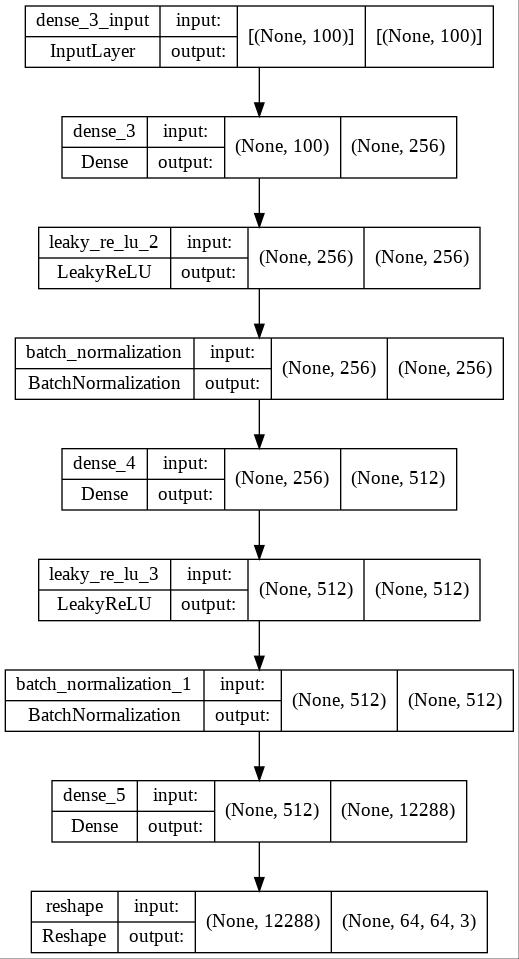

In [22]:
tf.keras.utils.plot_model(generator,to_file=image_path + folder+'/gen_archi.jpg',show_shapes=True)

# PLOT ALL HISTORY

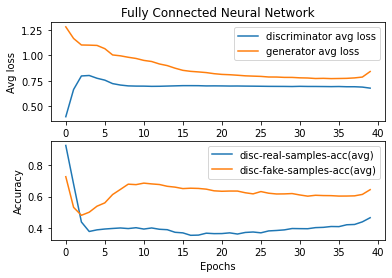

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [23]:
# Plot all history
plot_history(g_epoch_loss, d_epoch_loss, d1_epoch_acc, d2_epoch_acc)

# Plotting the Discriminator and Generator losses (Comparison)

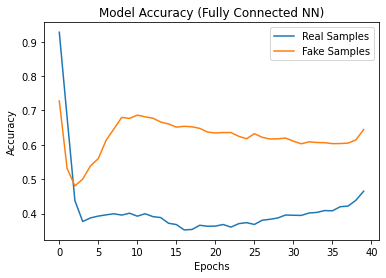

In [24]:
plt.plot(d1_epoch_acc, label='disc-real-samples-acc(avg)')
plt.plot(d2_epoch_acc, label='disc-fake-samples-acc(avg)')
plt.title('Model Accuracy (Fully Connected NN)')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Real Samples','Fake Samples'],loc='upper right')
plt.savefig(image_path + folder + '/generator_discriminator_accuracy.jpg')
plt.show()

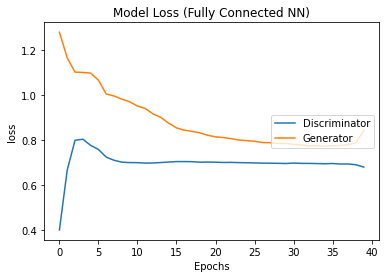

In [25]:
plt.plot(d_epoch_loss)
plt.plot(g_epoch_loss)
plt.title('Model Loss (Fully Connected NN)')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Discriminator','Generator'],loc='center right')
plt.savefig(image_path + folder + '/generator_discriminator_loss.jpg')
plt.show()

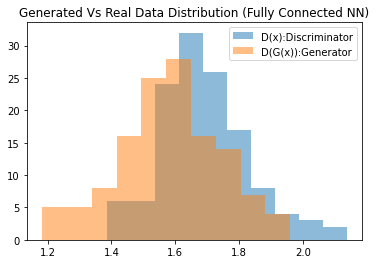

In [26]:
rand_seed = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
plt.title('Generated Vs Real Data Distribution (Fully Connected NN)')
plt.hist(np.exp(discriminator.predict(training_data[0:BATCH_SIZE])),label='D(x):Discriminator', alpha=0.5)
plt.hist(np.exp(discriminator.predict(generator.predict(rand_seed))),label='D(G(x)):Generator', alpha=0.5)
plt.legend(loc='best')
plt.savefig(image_path + folder + '/gen_disc_distribution.jpg')
plt.show()

# Create Gif Images

In [27]:
import imageio
images_to_gif = []
for filename in os.listdir(image_path+ folder):
  if filename.endswith('.png'):
    images_to_gif.append(imageio.imread(image_path + folder +'/' + filename))
imageio.mimsave(image_path + folder + '/movie'+str(IMG_SIZE)+'.gif', images_to_gif)
#shutil.rmtree(image_path + folder)

# Testing GAN model

##1. Load the Generator and Discriminator model

In [28]:
gen = tf.keras.models.load_model(image_path + folder +'/generator_' +str(IMG_SIZE)+'.h5')
disc = tf.keras.models.load_model(image_path + folder +'/discriminator_' +str(IMG_SIZE)+'.h5')

##2. Prediction 

### Generator Prediction

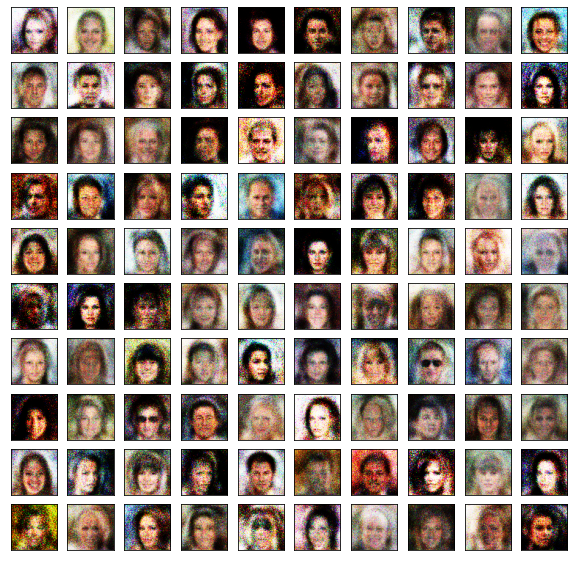

In [29]:
no_of_display = 100

rand_seed = np.random.normal(size=(no_of_display, LATENT_DIM))
fake_img = gen.predict(rand_seed)

#fake_img = fake_img.clip(np.min(training_data), np.max(training_data))

figure = plt.figure(figsize=(10,10))
for i in range(no_of_display): 
    plt.subplot(int(np.sqrt(no_of_display)), int(np.sqrt(no_of_display)), i+1)
    plt.imshow(((fake_img[i]*127.5)+127.5).astype('int'))
    #plt.imshow((fake_img[i]*255).astype('uint8'))
    #plt.imshow(fake_img[i], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])


### Discriminator Prediction

In [30]:
def disc_prediction(samples):
  decision = disc(samples)
  if decision.numpy()[0]<0.5:
    print('Fake Samples')
  else:
    print('Real samples')

Fake Samples


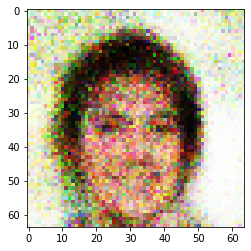

In [31]:
# Fake Samples
rand_seed = np.random.normal(size=(1, 100))
fake_img = gen.predict(rand_seed)
disc_prediction(fake_img)
plt.imshow(((fake_img[0]*127.5) + 127.5).astype('int'))

At  34754 th position in Real Samples
Real samples


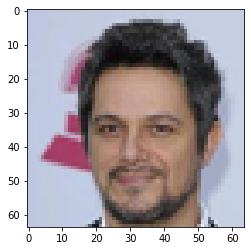

In [32]:
# Real Samples
          # training_data.shape = (60000, 64, 64, 3)
          # training_data[0,:,:,:].shape = (64, 64, 3)  at 0th position
          # But discriminator model requires (1,64,64,3) for 1 sample

# Random image position
choice = np.random.choice(range(0, len(training_data)))
print('At ',choice,'th position in Real Samples')
real_img = np.reshape(training_data[choice,:,:,:],(-1,IMG_SIZE,IMG_SIZE,3)).astype('float32')
disc_prediction(real_img)
plt.imshow(((training_data[choice]*127.5) + 127.5).astype('int'))